In [1]:
import pandas as pd
import re

# Import required libraries
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn import metrics
from matplotlib import pyplot
import seaborn as sns
# sns.set(style= "darkgrid", color_codes = True)
from catboost import CatBoostClassifier
import pandas as pd
from numpy import mean
from numpy import std

import warnings
warnings.filterwarnings('ignore')

In [9]:
file_path = "dataset_cleaned_oversampling.csv"
df = pd.read_csv(file_path)
print(df.shape)
print(df.info()) 

(21678, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21678 entries, 0 to 21677
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             21678 non-null  float64
 1   Gender          21678 non-null  float64
 2   BMI             21678 non-null  float64
 3   SBP             21678 non-null  float64
 4   DBP             21678 non-null  float64
 5   FPG             21678 non-null  float64
 6   Chol            21678 non-null  float64
 7   Tri             21678 non-null  float64
 8   HDL             21678 non-null  float64
 9   LDL             21678 non-null  float64
 10  ALT             21678 non-null  float64
 11  AST             21678 non-null  float64
 12  BUN             21678 non-null  float64
 13  CCR             21678 non-null  float64
 14  FFPG            21678 non-null  float64
 15  smoking         21678 non-null  int64  
 16  drinking        21678 non-null  int64  
 17  family_history  216

In [10]:
df_train = df[df['dataset'] == 'train']
df_val = df[df['dataset'] == 'validation']
df_test = df[df['dataset'] == 'test']

X_train = df_train.drop(columns=['Diabetes', 'dataset'])
y_train = df_train['Diabetes']

X_val = df_val.drop(columns=['Diabetes', 'dataset'])
y_val = df_val['Diabetes']

X_test = df_test.drop(columns=['Diabetes', 'dataset'])
y_test = df_test['Diabetes']

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (17530, 18)
Validation shape: (2074, 18)
Test shape: (2074, 18)


In [16]:
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(X_train)
scaled_x_val = scaler.transform(X_val)
scaled_x_test = scaler.transform(X_test)

In [ ]:
param_grid = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.05, 0.01, 0.1],
    'max_depth': [2, 4, 6, 8],
    'l2_leaf_reg' : [2,4,6,8],
    'rsm' : [0.3,0.5,0.6],
}


model = CatBoostClassifier()

# Perform grid search to find the best hyperparameters
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search.fit(scaled_x_train,y_train)

# Print the best hyperparameters and the corresponding score
print("Best score: {:.4f}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

0:	learn: 0.6166274	total: 146ms	remaining: 21.8s
1:	learn: 0.5521903	total: 154ms	remaining: 11.4s
2:	learn: 0.4988022	total: 163ms	remaining: 7.99s
3:	learn: 0.4527288	total: 170ms	remaining: 6.19s
4:	learn: 0.4133587	total: 178ms	remaining: 5.16s
5:	learn: 0.3799253	total: 184ms	remaining: 4.41s
6:	learn: 0.3500634	total: 193ms	remaining: 3.94s
7:	learn: 0.3231808	total: 199ms	remaining: 3.53s
8:	learn: 0.2994270	total: 209ms	remaining: 3.27s
9:	learn: 0.2781208	total: 215ms	remaining: 3.01s
10:	learn: 0.2605876	total: 221ms	remaining: 2.79s
11:	learn: 0.2412247	total: 227ms	remaining: 2.61s
12:	learn: 0.2264146	total: 233ms	remaining: 2.46s
13:	learn: 0.2116182	total: 242ms	remaining: 2.35s
14:	learn: 0.1998094	total: 248ms	remaining: 2.23s
15:	learn: 0.1867920	total: 256ms	remaining: 2.15s
16:	learn: 0.1756837	total: 262ms	remaining: 2.05s
17:	learn: 0.1666957	total: 270ms	remaining: 1.98s
18:	learn: 0.1576961	total: 276ms	remaining: 1.91s
19:	learn: 0.1500515	total: 285ms	remaini

In [17]:
model = CatBoostClassifier(verbose=0, eval_metric='Accuracy',iterations=150, learning_rate=0.1 ,max_depth=4 ,l2_leaf_reg=6 ,rsm=0.6)
model.fit(scaled_x_train, y_train)
y_pred = model.predict(scaled_x_val)

cv = StratifiedKFold(n_splits=10)

n_scores = cross_val_score(model, scaled_x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print("Accuracy score (training): {0:.3f}".format(model.score(scaled_x_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(model.score(scaled_x_val, y_val)))

Mean Accuracy: 0.982 (0.010)
Accuracy score (training): 0.985
Accuracy score (validation): 0.973


In [18]:
print(classification_report(y_val,y_pred))
cm = confusion_matrix(y_val, y_pred)
print('Confusion Matrix : \n', cm)

total=sum(sum(cm))
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity)
print('f1 score:', f1_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1878
           1       0.82      0.92      0.87       196

    accuracy                           0.97      2074
   macro avg       0.91      0.95      0.93      2074
weighted avg       0.98      0.97      0.97      2074

Confusion Matrix : 
 [[1838   40]
 [  15  181]]
Sensitivity :  0.9787007454739084
Specificity :  0.923469387755102
f1 score: 0.86810551558753


<Axes: >

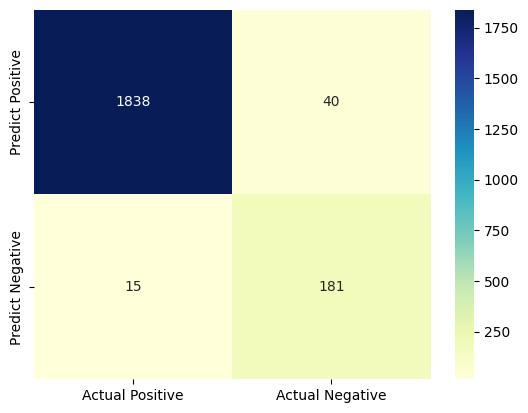

In [14]:
cm_matrix = pd.DataFrame(
    data=cm,
    columns=["Actual Positive", "Actual Negative"],
    index=["Predict Positive", "Predict Negative"],
)

sns.heatmap(cm_matrix, annot=True, fmt="d", cmap="YlGnBu")

In [19]:
# Prediksi di test set
y_test_pred = model.predict(scaled_x_test)

print("\n=== Evaluation on Test Set ===")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
print('Confusion Matrix (Test Set): \n', cm_test)

# Hitung Sensitivity & Specificity di TEST
sensitivity_test = cm_test[0,0]/(cm_test[0,0]+cm_test[0,1])
specificity_test = cm_test[1,1]/(cm_test[1,0]+cm_test[1,1])
print('Sensitivity (Test): ', sensitivity_test)
print('Specificity (Test): ', specificity_test)


=== Evaluation on Test Set ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1879
           1       0.89      0.92      0.90       195

    accuracy                           0.98      2074
   macro avg       0.94      0.96      0.95      2074
weighted avg       0.98      0.98      0.98      2074

Confusion Matrix (Test Set): 
 [[1856   23]
 [  15  180]]
Sensitivity (Test):  0.9877594465141033
Specificity (Test):  0.9230769230769231
